In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


import os
import sys

sys.path.append(os.path.abspath('..'))

from src.modeling import load_features, time_aware_split, infer_feature_types


In [3]:
df = load_features()  # loads data/processed/loan_data_features.csv
TARGET = "AFFORDABILITY"
df = df[df[TARGET].notna()].copy()


In [4]:
train_df, test_df = time_aware_split(df, date_col="LoanDate", test_size=0.2)


In [5]:
num_cols, cat_cols, dropped = infer_feature_types(train_df, target=TARGET)
print("Numeric:", num_cols[:10], "...")
print("Categorical:", cat_cols[:10], "...")
print("Dropped by name pattern:", dropped)


Numeric: ['Basic Salary', 'Payment', 'Age', 'Tenure', 'LoanAmount', 'DisbursementAmount', 'Instalment', 'PrincipalBalance', 'InterestRate', 'DebtToIncome'] ...
Categorical: ['Regions', 'Gender', 'LoanStatus', 'LoanPurpose', 'IsNPL'] ...
Dropped by name pattern: ['ID number', 'Personnel Number', 'LoanId', 'LoanDate', 'DisbursementDate', 'LastPaymentDate', 'RetirementDate', 'PrincipalPaidPct']


In [6]:
X_train = train_df[num_cols + cat_cols]
y_train = train_df[TARGET]
X_test  = test_df[num_cols + cat_cols]
y_test  = test_df[TARGET]


In [7]:
#Repeatable processing

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)


In [8]:
models = {
    "Linear": Pipeline([('pre', preprocessor), ('model', LinearRegression())]),
    "RidgeCV": Pipeline([('pre', preprocessor), ('model', RidgeCV())]),
    "LassoCV": Pipeline([('pre', preprocessor), ('model', LassoCV())]),
    "RandomForest": Pipeline([('pre', preprocessor), ('model', RandomForestRegressor(n_estimators=100, random_state=42))])
}


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    # compute RMSE manually
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

metrics_df = pd.DataFrame(results)
metrics_df


,model,MAE,RMSE,R2
0,Linear,172.265590,360.657134,0.962712
1,RidgeCV,172.568904,360.769671,0.962689
2,LassoCV,171.383135,361.391716,0.962560
3,RandomForest,108.557377,314.129618,0.971712


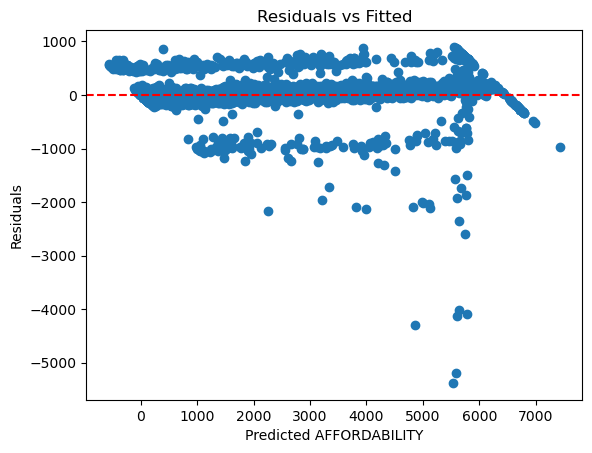

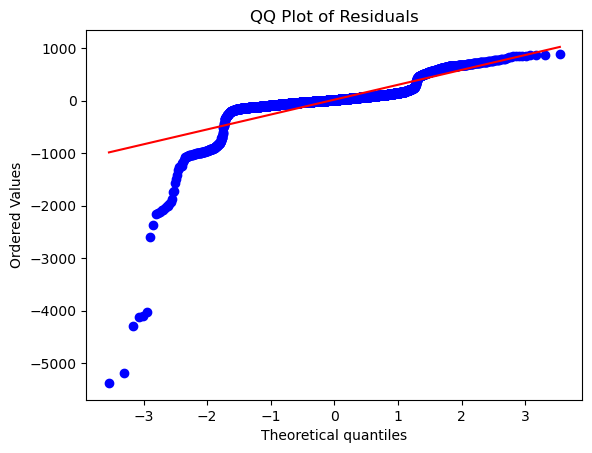

In [11]:
final_model = models["Linear"]
y_pred_train = final_model.predict(X_train)
y_pred_test  = final_model.predict(X_test)

# Residuals
residuals = y_test - y_pred_test

# Residual vs Fitted
plt.scatter(y_pred_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted AFFORDABILITY")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

# QQ plot
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()
